### 국토안전관리원_빅데이터를 활용한 AI 기반 건설현장 점검 대상 선정 데이터셋

##### 공사비 1000억 기준 구간화 및 공사비별 사고여부 시각화

In [12]:
# '공사범주'를 정의하는 함수를 만듭니다.
def categorize_construction_cost(cost):
    cost = str(cost)  # cost 값을 문자열로 변환합니다.
    if cost == '1억이하':  # '1억이하'는 명확히 2천만원 미만으로 가정
        return '1000억 미만'
    elif '10억초과 20억이하' in cost or '5억초과 10억이하' in cost or '1억초과 5억이하' in cost:
        return '1000억 미만'
    elif '20억초과 30억이하' in cost or '30억초과 40억이하' in cost or '40억초과 50억이하' in cost:
        return '1000억 미만'
    elif '50억초과 60억이하' in cost or '60억초과 70억이하' in cost or '70억초과 80억이하' in cost or '80억초과 90억이하' in cost or '90억초과 100억이하' in cost:
        return '1000억 미만'
    elif '100억초과 200억이하' in cost or '200억초과 300억이하' in cost or '300억초과 400억이하' in cost or '400억초과 500억이하' in cost or '500억초과 1000억이하' in cost:
        return '1000억 미만'
    elif '1000억초과 2000억이하' in cost or '2000억초과' in cost:
        return '1000억 이상'
    else:
        return '분류불능'  # 위 조건에 해당하지 않는 모든 경우를 '800억원 이상'으로 분류

# # 기존 데이터프레임에 '공사범주'라는 새로운 컬럼을 추가합니다.
# df1_clean['공사범주'] = df1_clean['공사비'].apply(categorize_construction_cost)

# # 결과 확인
# df1_clean[['공사비', '공사범주']].head()

# 기존 데이터프레임에 '공사범주'라는 새로운 컬럼을 추가합니다.
df1.loc[:, '공사비_구간_재조정'] = df1['공사비'].apply(categorize_construction_cost)


# 결과 확인
df1[['공사비', '공사비_구간_재조정']].head()


,공사비,공사비_구간_재조정
0,100억초과 200억이하,1000억 미만
1,100억초과 200억이하,1000억 미만
2,100억초과 200억이하,1000억 미만
3,100억초과 200억이하,1000억 미만
4,20억초과 30억이하,1000억 미만


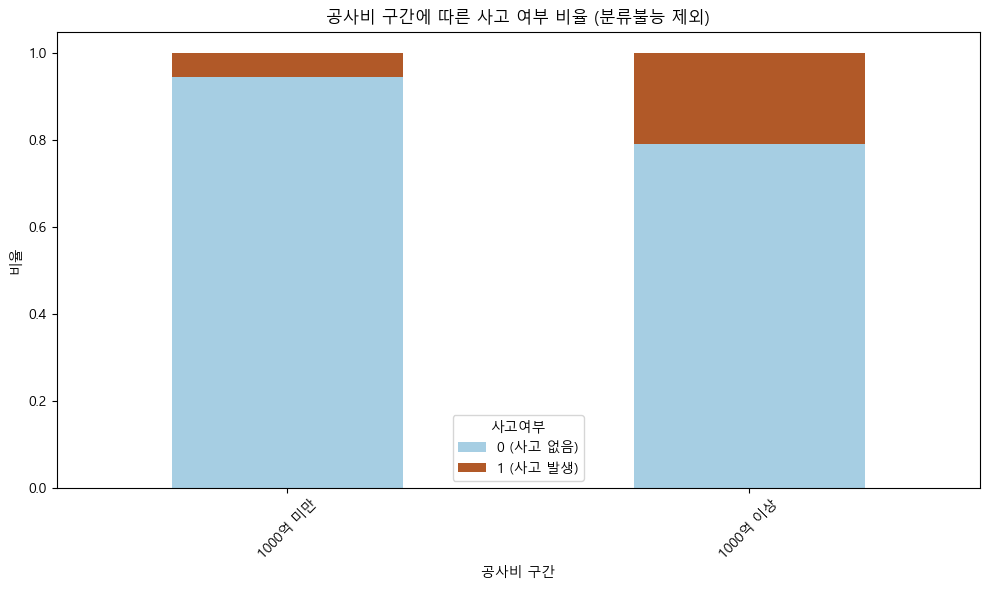

In [14]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest

# 환경 설정
import matplotlib
# 한글 설치(윈도우 버전)
matplotlib.rc('font', family='Malgun Gothic')
# 음수 표시
matplotlib.rc('axes', unicode_minus=False)
# 그래프 출력
%matplotlib inline

# 실행결과 경고메시지 출력 제외
import warnings
warnings.filterwarnings('ignore')

# '분류불능' 데이터 제외
df_filtered = df1[df1['공사비_구간_재조정'] != '분류불능']

# 공사비 구간별 사고 여부에 따른 데이터 그룹핑
df_grouped_filtered = df_filtered.groupby(['공사비_구간_재조정', '사고여부']).size().unstack(fill_value=0)

# 사고여부 0과 1의 비율 계산
df_grouped_filtered = df_grouped_filtered.div(df_grouped_filtered.sum(axis=1), axis=0)

# 공사비 구간에 따른 사고 여부 비율 시각화
df_grouped_filtered.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Paired')

plt.title('공사비 구간에 따른 사고 여부 비율 (분류불능 제외)')
plt.xlabel('공사비 구간')
plt.ylabel('비율')
plt.xticks(rotation=45)
plt.legend(title='사고여부', labels=['0 (사고 없음)', '1 (사고 발생)'])
plt.tight_layout()
plt.show()


##### 1000억대별 사고여부 검정

- 데이터에서 1000억 미만 구간과 1000억 이상 구간 사이에 사고 발생 비율에서 유의한 차이가 있음
- 공사비 구간이 사고 발생 여부에 영향을 미친다고 결론 지을 수 있습니다.

- P-value: 2.675859609916541e-97

In [115]:
import scipy.stats as stats

# 교차표 생성
contingency_table = pd.crosstab(df1['공사비_구간_재조정'], df1['사고여부'])

# '분류불능' 행 제거
contingency_table_cleaned = contingency_table.drop(index='분류불능')

# # 교차표 출력 확인
# print("Cleaned Contingency Table:")
# print(contingency_table_cleaned)

# 카이제곱 검정 실행
chi2_stat, p_val, dof, expected = stats.chi2_contingency(contingency_table_cleaned)

print(f"Chi2 Stat: {chi2_stat}")
print(f"P-value: {p_val}")
print(f"Degrees of Freedom: {dof}")
print(f"Expected Frequencies:\n{expected}")



Chi2 Stat: 438.1941833906145
P-value: 2.675859609916541e-97
Degrees of Freedom: 1
Expected Frequencies:
[[15067.03635838  1041.96364162]
 [ 1113.96364162    77.03635838]]


##### 토목,건축의 공사비별 사고여부 시각화 및 검정

- P-Value: 1.9860787721390448e-161

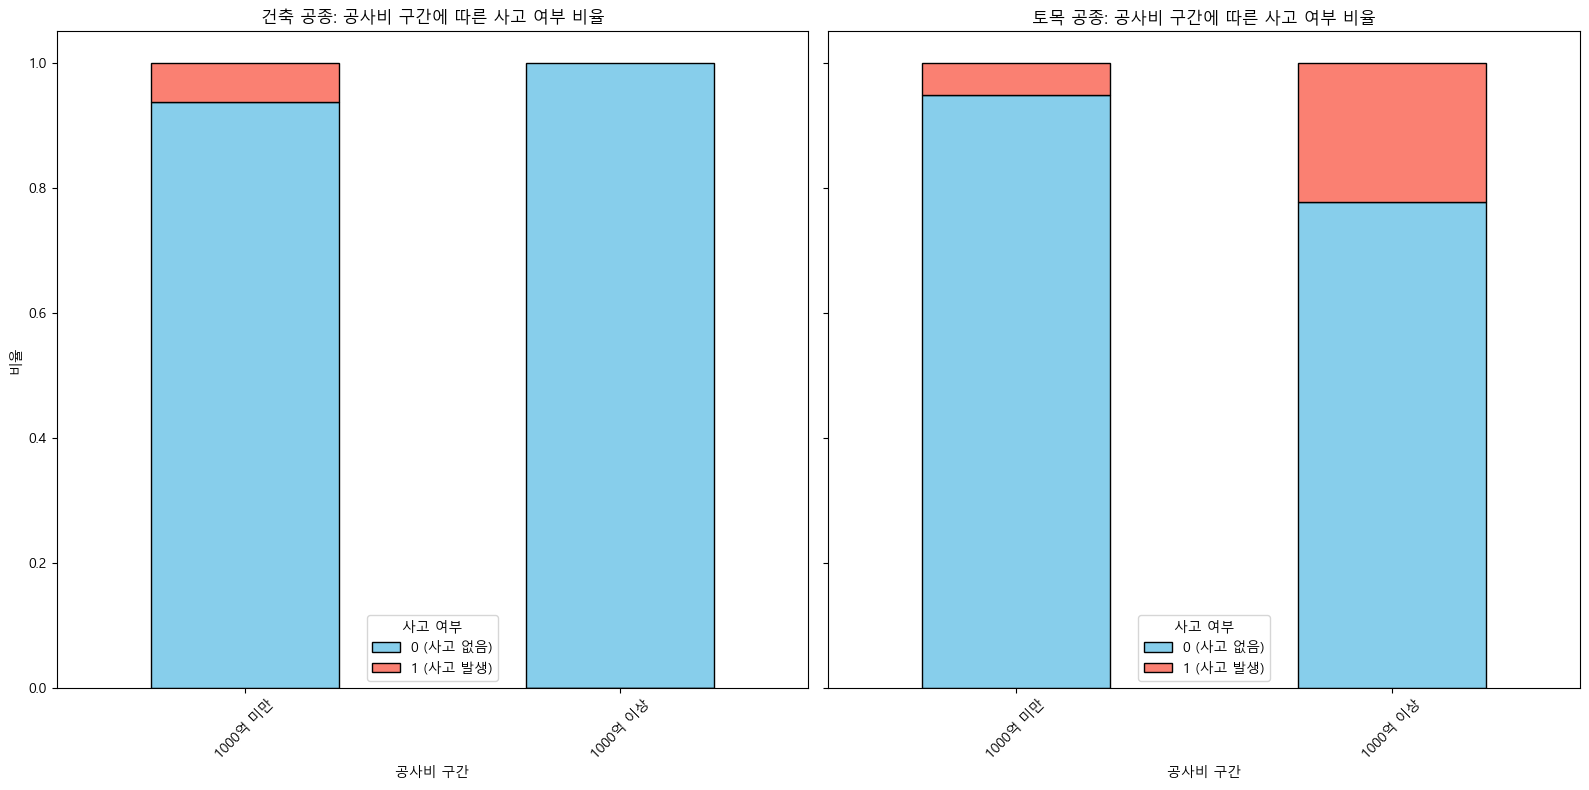

In [150]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 데이터 준비
df_grouped = df1.groupby(['공종', '공사비_구간_재조정', '사고여부']).size().unstack(fill_value=0)
df_grouped = df_grouped.div(df_grouped.sum(axis=1), axis=0).reset_index()  # 비율로 변환 및 리셋 인덱스
df_grouped = df_grouped.melt(id_vars=['공종', '공사비_구간_재조정'], var_name='사고여부', value_name='비율')


# '분류불능'을 제거
df_grouped = df_grouped[df_grouped['공사비_구간_재조정'] != '분류불능']


# 공종별로 데이터 필터링
df_building = df_grouped[df_grouped['공종'] == '건축']
df_civil = df_grouped[df_grouped['공종'] == '토목']



# 시각화
fig, axs = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# 건축 공종 시각화
df_building_pivot = df_building.pivot(index='공사비_구간_재조정', columns='사고여부', values='비율').fillna(0)
df_building_pivot.plot(kind='bar', stacked=True, ax=axs[0], color=['skyblue', 'salmon'], edgecolor='black')
axs[0].set_title('건축 공종: 공사비 구간에 따른 사고 여부 비율')
axs[0].set_xlabel('공사비 구간')
axs[0].set_ylabel('비율')
axs[0].legend(title='사고 여부', labels=['0 (사고 없음)', '1 (사고 발생)'])
axs[0].tick_params(axis='x', rotation=45)

# 토목 공종 시각화
df_civil_pivot = df_civil.pivot(index='공사비_구간_재조정', columns='사고여부', values='비율').fillna(0)
df_civil_pivot.plot(kind='bar', stacked=True, ax=axs[1], color=['skyblue', 'salmon'], edgecolor='black')
axs[1].set_title('토목 공종: 공사비 구간에 따른 사고 여부 비율')
axs[1].set_xlabel('공사비 구간')
axs[1].set_ylabel('비율')
axs[1].legend(title='사고 여부', labels=['0 (사고 없음)', '1 (사고 발생)'])
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
# 데이터 준비
# df1 데이터프레임에서 '공종'과 '사고여부' 열을 사용하여 교차표를 생성합니다.
contingency_table = pd.crosstab(df1['공종'], df1['사고여부'])

# 카이제곱 독립성 검정 수행
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

# 결과 출력
print("Chi-Square Statistic:", chi2_stat)
print("P-Value:", p_value)
print("Degrees of Freedom:", dof)
print("Expected Frequencies Table:")
print(expected)

# 결과 해석
alpha = 0.05
if p_value < alpha:
    print("유의수준 0.05에서, 공종과 사고 여부 간에는 통계적으로 유의한 관계가 있습니다.")
else:
    print("유의수준 0.05에서, 공종과 사고 여부 간에는 통계적으로 유의한 관계가 없습니다.")